## Will Millennials Ever Get Married?

This notebook contains analysis related to a paper on marriage patterns in the U.S., based on data from the National Survey of Family Growth (NSFG).

It is based on Chapter 13 of Think Stats, 2nd Edition, by Allen Downey, available from [thinkstats2.com](http://thinkstats2.com)

In [1]:
from __future__ import print_function, division

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import math

import matplotlib.pyplot as plt
from matplotlib import pylab

from scipy.interpolate import interp1d
from scipy.misc import derivative

import thinkstats2
import thinkplot
from thinkstats2 import Cdf

import survival
import marriage

Validating the 2015 data:

In [2]:
resp9 = marriage.ReadFemResp2015()
marriage.Validate2015(resp9)

In [3]:
resp9.head()

,caseid,cmbirth,evrmarry,cmmarrhx,cmdivorcx,parity,wgt2013_2015,cmintvw,finalwgt,cycle,agemarry,age,missing,year,age_index,agemarry_index,birth_index
0,60418,921,True,1159,1269,3,3554.964843,1381,3554.964843,9,19.833333,38.333333,False,76,38,19,70
1,60419,942,True,1207,1253,0,2484.535358,1388,2484.535358,9,22.083333,37.166667,False,78,37,22,70
2,60420,981,False,NaN,NaN,1,2903.782914,1388,2903.782914,9,NaN,33.916667,False,81,33,NaN,80
3,60423,1010,False,NaN,NaN,2,2738.498331,1387,2738.498331,9,NaN,31.416667,False,84,31,NaN,80
4,60426,897,True,1256,NaN,1,9682.211381,1368,9682.211381,9,29.916667,39.250000,False,74,39,29,70


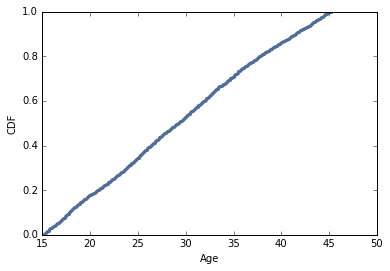

In [4]:
thinkplot.Cdf(Cdf(resp9.age))
thinkplot.Config(xlabel='Age', ylabel='CDF')

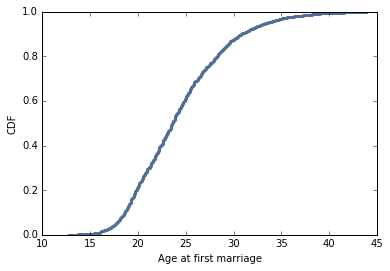

In [5]:
thinkplot.Cdf(Cdf(resp9.agemarry))
thinkplot.Config(xlabel='Age at first marriage', ylabel='CDF')

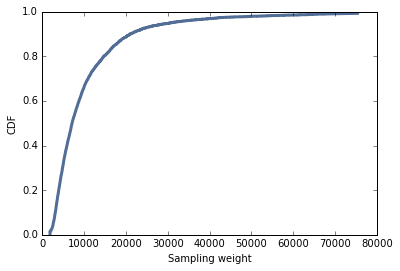

In [6]:
thinkplot.Cdf(Cdf(resp9.finalwgt))
thinkplot.Config(xlabel='Sampling weight', ylabel='CDF')

Loading the rest of the data

In [7]:
resp8 = marriage.ReadFemResp2013()
marriage.Validate2013(resp8)

resp7 = marriage.ReadFemResp2010()
marriage.Validate2010(resp7)

resp6 = marriage.ReadFemResp2002()
marriage.Validate2002(resp6)

resp5 = marriage.ReadFemResp1995()
marriage.Validate1995(resp5)

resp4 = marriage.ReadFemResp1988()
marriage.Validate1988(resp4)

resp3 = marriage.ReadFemResp1982()
marriage.Validate1982(resp3)

Make a list of DataFrames, one for each cycle:

In [8]:
resps = [resp9, resp8, resp7, resp6, resp5, resp4, resp3]
#resps = [resp9]

Make a table showing the number of respondents in each cycle:

In [9]:
def SummarizeCycle(df):
    ages = df.age.min(), df.age.max()
    ages= np.array(ages)
    
    intvws = df.cmintvw.min(), df.cmintvw.max()
    intvws = np.array(intvws) / 12 + 1900
    
    births = df.cmbirth.min(), df.cmbirth.max()
    births = np.array(births) / 12 + 1900

    print('# & ', intvws.astype(int), '&', len(df), '&', births.astype(int), r'\\')
    
for resp in reversed(resps):
    SummarizeCycle(resp)

# &  [1982 1983] & 7969 & [1937 1968] \\
# &  [1988 1988] & 8450 & [1943 1973] \\
# &  [1995 1995] & 10847 & [1950 1980] \\
# &  [2002 2003] & 7643 & [1957 1988] \\
# &  [2006 2010] & 12279 & [1961 1995] \\
# &  [2011 2013] & 5601 & [1966 1998] \\
# &  [2013 2015] & 5699 & [1968 2000] \\


Check for missing values in `agemarry`:

In [10]:
def CheckAgeVars(df):
    print(sum(df[df.evrmarry].agemarry.isnull()))
    
for resp in resps:
    CheckAgeVars(resp)

11
17
16
37
0
0
0


Combine the DataFrames (but remember that this is not resampled properly):

In [11]:
df = pd.concat(resps, ignore_index=True)
len(df)

58488

In [51]:
df.to_csv('FemMarriageData.csv')

Double check missing data:

In [12]:
sum(df.missing)

81

Generate a table with the number of respondents in each cohort:

In [13]:
marriage.DigitizeResp(df)
grouped = df.groupby('birth_index')
for name, group in iter(grouped):
    print(name, '&', len(group), '&', int(group.age.min()), '--', int(group.age_index.max()),
                '&', len(group[group.evrmarry]), '&', sum(group.missing), r'\\')

30 & 325 & 42 -- 45 & 310 & 0 \\
40 & 3608 & 32 -- 45 & 3275 & 0 \\
50 & 10631 & 22 -- 45 & 8658 & 10 \\
60 & 14558 & 15 -- 45 & 8484 & 28 \\
70 & 13700 & 14 -- 45 & 7090 & 30 \\
80 & 10637 & 14 -- 35 & 3218 & 13 \\
90 & 5014 & 15 -- 25 & 234 & 0 \\
100 & 15 & 15 -- 15 & 0 & 0 \\


In [14]:
def ComputeCutoffs(df):
    grouped = df.groupby('birth_index')
    cutoffs = {}
    for name, group in sorted(grouped):
        cutoffs[name] = int(group.age.max())
    return cutoffs

cutoffs = ComputeCutoffs(df)
cutoffs

{30: 45, 40: 45, 50: 45, 60: 45, 70: 45, 80: 35, 90: 25, 100: 15}

Estimate the hazard function for the 80s cohort (curious to see what's going on during the "marriage strike")

In [15]:
cohort = grouped.get_group(80)
missing = (cohort.evrmarry & cohort.agemarry.isnull())
cohort = cohort[~missing]
complete = cohort[cohort.evrmarry].agemarry_index
ongoing = cohort[~cohort.evrmarry].age_index
hf = survival.EstimateHazardFunction(complete, ongoing, verbose=True)

13.0 10624 8 0 0.000753012048193
14.0 10616 9 14 0.000847776940467
15.0 10593 31 260 0.00292646087039
16.0 10302 82 242 0.00795961949136
17.0 9978 103 338 0.0103227099619
18.0 9537 271 460 0.0284156443326
19.0 8806 358 569 0.0406540994776
20.0 7879 346 579 0.0439142023099
21.0 6954 352 572 0.0506183491516
22.0 6030 361 572 0.0598673300166
23.0 5097 303 454 0.0594467333726
24.0 4340 286 533 0.0658986175115
25.0 3521 250 576 0.071002556092
26.0 2695 154 531 0.0571428571429
27.0 2010 119 447 0.0592039800995
28.0 1444 79 322 0.0547091412742
29.0 1043 48 283 0.046021093001
30.0 712 26 199 0.0365168539326
31.0 487 15 180 0.0308008213552
32.0 292 2 147 0.00684931506849
33.0 143 2 83 0.013986013986
34.0 58 0 42 0.0
35.0 16 0 16 0.0


Run the same analysis for the 70s cohort (to extract $\lambda(33)$).

In [16]:
cohort = grouped.get_group(70)
missing = (cohort.evrmarry & cohort.agemarry.isnull())
cohort = cohort[~missing]
complete = cohort[cohort.evrmarry].agemarry_index
ongoing = cohort[~cohort.evrmarry].age_index
hf = survival.EstimateHazardFunction(complete, ongoing, verbose=True)

10.0 13670 1 0 7.31528895391e-05
11.0 13669 1 0 7.31582412759e-05
12.0 13668 3 0 0.000219490781387
13.0 13665 7 0 0.000512257592389
14.0 13658 27 3 0.00197686337678
15.0 13628 58 388 0.00425594364544
16.0 13182 153 518 0.0116067364588
17.0 12511 231 540 0.0184637518983
18.0 11740 503 340 0.0428449744463
19.0 10897 594 268 0.0545104157107
20.0 10035 572 242 0.0570004982561
21.0 9221 616 220 0.0668040342696
22.0 8385 613 264 0.073106738223
23.0 7508 599 347 0.0797815663292
24.0 6562 545 345 0.0830539469674
25.0 5672 492 205 0.0867418899859
26.0 4975 433 149 0.0870351758794
27.0 4393 313 164 0.0712497154564
28.0 3916 330 198 0.0842696629213
29.0 3388 257 215 0.0758559622196
30.0 2916 203 315 0.0696159122085
31.0 2398 130 278 0.0542118432027
32.0 1990 115 212 0.0577889447236
33.0 1663 76 155 0.0457005411906
34.0 1432 63 173 0.0439944134078
35.0 1196 45 216 0.0376254180602
36.0 935 21 198 0.0224598930481
37.0 716 19 162 0.0265363128492
38.0 535 14 121 0.0261682242991
39.0 400 10 106 0.025
4

Use the 30s cohort to demonstrate the simple way to do survival analysis, by computing the survival function directly.

[ 0.99384615  0.96923077  0.94769231  0.90153846  0.81846154  0.68615385
  0.56        0.46461538  0.36307692  0.29538462  0.26153846  0.23384615
  0.21230769  0.17538462  0.14769231  0.13230769  0.11076923  0.10153846
  0.08923077  0.07692308  0.07384615  0.06461538  0.06153846  0.05846154
  0.05538462  0.04923077  0.04615385  0.        ]


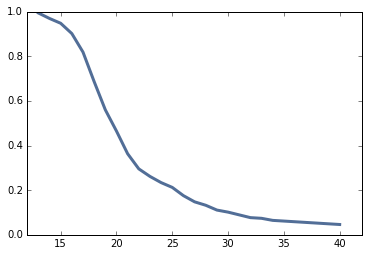

In [17]:
cohort = grouped.get_group(30)
sf = survival.MakeSurvivalFromSeq(cohort.agemarry_index.fillna(np.inf))
ts, ss = sf.Render()
print(ss)
thinkplot.Plot(ts, ss)
thinkplot.Config(xlim=[12, 42])

Then use the SurvivalFunction to compute the HazardFunction:

[ 0.00615385  0.0247678   0.02222222  0.0487013   0.09215017  0.16165414
  0.1838565   0.17032967  0.21854305  0.18644068  0.11458333  0.10588235
  0.09210526  0.17391304  0.15789474  0.10416667  0.1627907   0.08333333
  0.12121212  0.13793103  0.04        0.125       0.04761905  0.05
  0.05263158  0.11111111  0.0625      1.        ]


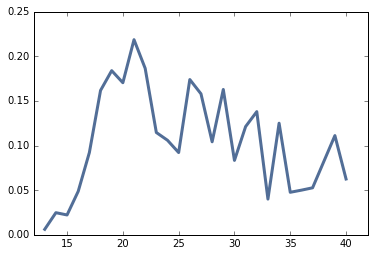

In [18]:
hf = sf.MakeHazardFunction()
ts, lams = hf.Render()
print(lams)
thinkplot.Plot(ts, lams)
thinkplot.Config(xlim=[12, 42])

Make the first figure, showing sf and hf for the 30s cohort:

In [19]:
options = dict(formats=['pdf', 'png'], clf=False)

Writing marriage1.pdf
Writing marriage1.png


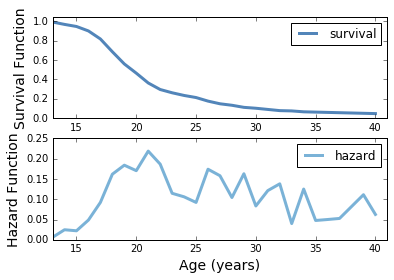

In [20]:
thinkplot.PrePlot(2, rows=2)

thinkplot.Plot(sf, label='survival')
thinkplot.Config(xlim=[13, 41], ylim=[0, 1.05])
plt.ylabel('Survival Function', fontsize=14)

thinkplot.SubPlot(2)
thinkplot.Plot(hf, label='hazard')
thinkplot.Config(xlabel='age(years)', ylabel='Hazard function', xlim=[13, 41])
plt.ylabel('Hazard Function', fontsize=14)
plt.xlabel('Age (years)', fontsize=14)

thinkplot.Save(root='marriage1', **options)

Writing marriage2.pdf
Writing marriage2.png


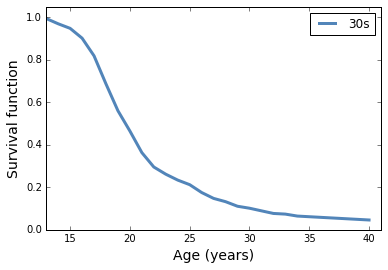

In [21]:
thinkplot.PrePlot(1)

thinkplot.Plot(sf, label='30s')
thinkplot.Config(xlim=[13, 41], ylim=[0, 1.05])
plt.xlabel('Age (years)', fontsize=14)
plt.ylabel('Survival function', fontsize=14)

thinkplot.Save(root='marriage2', **options)

Writing marriage3.pdf
Writing marriage3.png


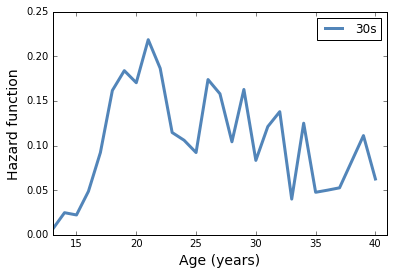

In [22]:
thinkplot.PrePlot(1)

thinkplot.Plot(hf, label='30s')
thinkplot.Config(xlim=[13, 41])
plt.xlabel('Age (years)', fontsize=14)
plt.ylabel('Hazard function', fontsize=14)

thinkplot.Save(root='marriage3', **options)

Make some pivot tables, just to see where the data are:

In [23]:
pt = df.pivot_table(index='birth_index', columns='age_index', values='age', aggfunc=len, fill_value=0)
pt

age_index,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,...,36.0,37.0,38.0,39.0,40.0,41.0,42.0,43.0,44.0,45.0
birth_index,,,,,,,,,,,,,,,,,,,,,
30,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,19,146,148,12
40,0,0,0,0,0,0,0,0,0,0,...,202,163,345,452,442,414,384,194,198,25
50,0,0,0,0,0,0,0,0,42,301,...,745,768,492,427,396,371,482,633,533,38
60,0,269,300,370,665,722,609,513,520,242,...,282,359,417,466,595,562,537,512,517,33
70,3,389,523,549,362,293,283,285,365,572,...,700,610,486,432,290,310,233,203,105,1
80,14,260,242,340,483,589,658,683,705,602,...,0,0,0,0,0,0,0,0,0,0
90,0,749,804,784,678,563,351,378,308,215,...,0,0,0,0,0,0,0,0,0,0
100,0,15,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The following pivot table is not as helpful as it could be, since it doesn't show the number at risk.

In [24]:
df.pivot_table(index='birth_index', columns='agemarry_index', values='age', aggfunc=len, fill_value=0)

agemarry_index,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,...,34.0,35.0,36.0,37.0,38.0,39.0,40.0,41.0,42.0,43.0
birth_index,,,,,,,,,,,,,,,,,,,,,
30,0,0,0,2,8,7,15,27,43,41,...,3,1,1,1,0,2,1,0,0,0
40,1,0,0,5,31,87,163,218,425,467,...,15,12,5,6,3,9,1,1,0,0
50,0,0,1,10,50,125,384,642,1111,1057,...,50,33,27,18,12,11,7,4,4,4
60,0,1,1,5,36,114,289,423,823,810,...,64,62,32,36,22,22,14,11,7,4
70,1,1,3,7,27,58,153,232,503,594,...,63,45,21,19,14,10,8,1,5,2
80,0,0,0,8,9,31,82,103,271,358,...,0,0,0,0,0,0,0,0,0,0
90,0,0,0,0,1,3,8,17,41,45,...,0,0,0,0,0,0,0,0,0,0


Estimate the survival curve for each cohort:

In [25]:
%time sf_map = marriage.EstimateSurvivalByCohort(resps, iters=101, cutoffs=cutoffs)
del sf_map[30]
del sf_map[100]

CPU times: user 28.2 s, sys: 204 ms, total: 28.4 s
Wall time: 28.4 s


Check a sample:

In [26]:
for sf in sf_map[90]:
    print(sf.ss)
    print(sf.Prob(34))
    break

14    0.999776
15    0.999329
16    0.998281
17    0.991923
18    0.977907
19    0.957845
20    0.929074
21    0.905750
22    0.842975
23    0.814688
24    0.814688
dtype: float64
0.814687620547


In [27]:
for sf in sf_map[80]:
    print(sf.ss)
    print(sf.Prob(34))
    break

13    0.999608
14    0.998434
15    0.995196
16    0.987540
17    0.977400
18    0.942875
19    0.904856
20    0.865113
21    0.815456
22    0.757044
23    0.703120
24    0.651549
25    0.588744
26    0.538129
27    0.483060
28    0.445936
29    0.416694
30    0.403204
31    0.391440
32    0.386442
33    0.378939
34    0.378939
dtype: float64
0.378938747197


Make the figure showing estimated survival curves:

Writing marriage4.pdf
Writing marriage4.png


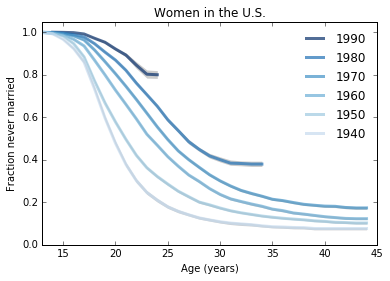

In [28]:
reload(marriage)
reload(thinkplot)

def PlotSurvivalFunctions(root, sf_map, sf_map_pred=None, **options):

    if sf_map_pred:
        marriage.PlotSurvivalFunctions(sf_map_pred, predict_flag=True)
    marriage.PlotSurvivalFunctions(sf_map)

    thinkplot.Config(xlim=[13, 45], ylim=[0, 1.05])
    thinkplot.Save(root=root, **options)

options_w = dict(formats=['pdf', 'png'], clf=False, title='Women in the U.S.', frameon=False)
PlotSurvivalFunctions('marriage4', sf_map, None, **options_w)

Make a table of marriage rates for each cohort at each age:

In [29]:
def MakeTable(sf_map, ages):
    t = []
    for name, sf_seq in sorted(sf_map.items()):
        ts, ss = marriage.MakeSurvivalCI(sf_seq, [50])
        ss = ss[0]
        vals = [np.interp(age, ts, ss, right=np.nan) for age in ages]
        t.append((name, vals))
    return t

In [30]:
def MakePercentageTable(sf_map, ages=[23, 33, 43]):
    t = MakeTable(sf_map, ages)
    for name, sf_seq in sorted(sf_map.items()):
        ts, ss = marriage.MakeSurvivalCI(sf_seq, [50])
        ss = ss[0]
        vals = [np.interp(age, ts, ss, right=np.nan) for age in ages]
        print(name, '&', ' & '.join('%0.0f' % (val*100) for val in vals), r'\\')
        
MakePercentageTable(sf_map)

40 & 25 & 9 & 8 \\
50 & 36 & 14 & 10 \\
60 & 52 & 19 & 12 \\
70 & 62 & 24 & 17 \\
80 & 71 & 38 & nan \\
90 & 80 & nan & nan \\


Generate projections:

In [31]:
%time sf_map_pred = marriage.EstimateSurvivalByCohort(resps, iters=101, cutoffs=cutoffs, predict_flag=True)
del sf_map_pred[30]
del sf_map_pred[100]

CPU times: user 29.9 s, sys: 184 ms, total: 30.1 s
Wall time: 30.1 s


And make the figure showing projections:

Writing marriage5.pdf
Writing marriage5.png


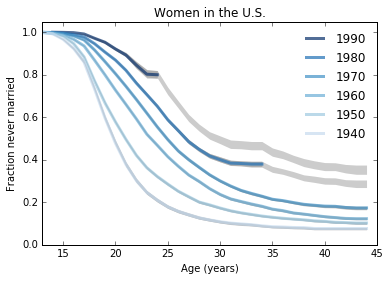

In [32]:
PlotSurvivalFunctions('marriage5', sf_map, sf_map_pred, **options_w)

Make the table again with the projections filled in.

In [33]:
MakePercentageTable(sf_map_pred)

40 & 25 & 9 & 8 \\
50 & 36 & 14 & 10 \\
60 & 52 & 19 & 12 \\
70 & 62 & 24 & 17 \\
80 & 71 & 38 & 29 \\
90 & 81 & 47 & 36 \\


In [34]:
def PlotFractions(sf_map, ages=[23, 33], label_flag=False, **options):
    t = MakeTable(sf_map, ages)
    cohorts, cols = zip(*t)
    rows = zip(*cols)

    thinkplot.PrePlot(3)
    for age, row in reversed(zip(ages, rows)):
        label = 'at age %d' % age if label_flag else ''
        thinkplot.Plot(cohorts, row, label=label, **options)

Writing marriage6.pdf
Writing marriage6.png


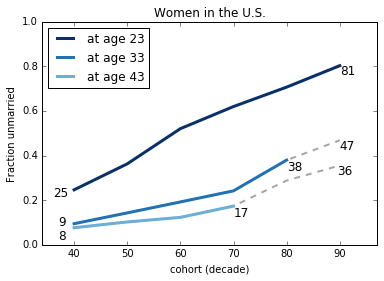

In [35]:
ages = [43, 33, 23]
PlotFractions(sf_map_pred, ages=ages, color='gray', linestyle='dashed', linewidth=2)
PlotFractions(sf_map, ages=ages, label_flag=True, alpha=1)

fontsize=12
thinkplot.Text(36, 0.26, '25', fontsize=fontsize)
thinkplot.Text(37, 0.13, '9', fontsize=fontsize)
thinkplot.Text(37, 0.07, '8', fontsize=fontsize)

thinkplot.Text(90, 0.81, '81', fontsize=fontsize)
thinkplot.Text(90, 0.47, '47', fontsize=fontsize)
thinkplot.Text(89.5, 0.36, '36', fontsize=fontsize)

thinkplot.Text(80, 0.38, '38', fontsize=fontsize)
thinkplot.Text(70, 0.17, '17', fontsize=fontsize)

thinkplot.Config(xlim=[34, 97], ylim=[0, 1], legend=True, loc='top left',
                 xlabel='cohort (decade)', ylabel='Fraction unmarried', 
                 title='Women in the U.S.')

thinkplot.Save(root='marriage6', **options)

## Marriage patterns for men

In [36]:
male2002 = marriage.ReadMaleResp2002()
male2002.head()

,caseid,cmbirth,evrmarry,cmdivw,mardat01,finalwgt,cmintvw,cmmarrhx,agemarry,age,missing,year,age_index,agemarry_index,birth_index
0,12178,1052,False,NaN,NaN,7085.207973,1233,NaN,NaN,15.083333,False,87,15,NaN,80
1,3233,701,True,NaN,1007,24372.450063,1237,1007,25.500000,44.666667,False,58,44,25,50
2,12170,707,True,NaN,1199,7073.132109,1234,1199,41.000000,43.916667,False,58,43,41,50
3,6629,1052,False,NaN,NaN,3105.158992,1234,NaN,NaN,15.166667,False,87,15,NaN,80
4,6531,787,True,NaN,1107,4679.548824,1235,1107,26.666667,37.333333,False,65,37,26,60


In [37]:
male2010 = marriage.ReadMaleResp2010()
male2010.head()

,caseid,cmbirth,evrmarry,cmdivw,mardat01,wgtq1q16,cmintvw,cmmarrhx,finalwgt,agemarry,age,missing,year,age_index,agemarry_index,birth_index
0,36133,1043,False,NaN,NaN,7270.577055,1323,NaN,7270.577055,NaN,23.333333,False,86,23,NaN,80
1,36636,1021,False,NaN,NaN,7601.733277,1322,NaN,7601.733277,NaN,25.083333,False,85,25,NaN,80
2,41125,1118,False,NaN,NaN,4587.699601,1322,NaN,4587.699601,NaN,17.000000,False,93,17,NaN,90
3,23607,948,False,NaN,NaN,26566.111007,1287,NaN,26566.111007,NaN,28.250000,False,78,28,NaN,70
4,40814,1018,False,NaN,NaN,5709.710317,1322,NaN,5709.710317,NaN,25.333333,False,84,25,NaN,80


In [38]:
male2013 = marriage.ReadMaleResp2013()
male2013.head()

,caseid,cmbirth,evrmarry,cmdivw,mardat01,wgt2011_2013,cmintvw,cmmarrhx,finalwgt,agemarry,age,missing,year,age_index,agemarry_index,birth_index
0,50001,1027,True,1346,1237,8111.081751,1348,1237,8111.081751,17.500000,26.750000,False,85,26,17,80
1,50003,1160,False,NaN,NaN,4082.414347,1354,NaN,4082.414347,NaN,16.166667,False,96,16,NaN,90
2,50006,1025,True,NaN,1335,25550.455475,1360,1335,25550.455475,25.833333,27.916667,False,85,27,25,80
3,50007,1028,False,NaN,NaN,6754.912773,1348,NaN,6754.912773,NaN,26.666667,False,85,26,NaN,80
4,50009,855,True,NaN,1152,49442.342886,1362,1152,49442.342886,24.750000,42.250000,False,71,42,24,70


In [39]:
male2015 = marriage.ReadMaleResp2015()
male2015.head()

,caseid,cmbirth,evrmarry,cmdivw,mardat01,wgt2013_2015,cmintvw,cmmarrhx,finalwgt,agemarry,age,missing,year,age_index,agemarry_index,birth_index
0,60417,926,False,NaN,NaN,7693.012917,1379,NaN,7693.012917,NaN,37.750000,False,77,37,NaN,70
1,60421,1161,False,NaN,NaN,9643.271157,1377,NaN,9643.271157,NaN,18.000000,False,96,18,NaN,90
2,60422,980,False,NaN,NaN,9650.615384,1376,NaN,9650.615384,NaN,33.000000,False,81,33,NaN,80
3,60424,990,True,NaN,1326,11590.039167,1376,1326,11590.039167,28.000000,32.166667,False,82,32,28,80
4,60425,1143,True,NaN,1376,6864.914673,1383,1376,6864.914673,19.416667,20.000000,False,95,20,19,90


In [40]:
males = [male2002, male2010, male2013, male2015]
df2 = pd.concat(males, ignore_index=True)
len(df2)

24652

In [41]:
sum(df2.missing)

0

In [42]:
marriage.DigitizeResp(df2)
grouped = df2.groupby('birth_index')
for name, group in iter(grouped):
    print(name, '&', len(group), '&', int(group.age.min()), '--', int(group.age_index.max()),
                '&', len(group[group.evrmarry]), '&', sum(group.missing), r'\\')

50 & 322 & 42 -- 45 & 225 & 0 \\
60 & 3668 & 32 -- 45 & 2530 & 0 \\
70 & 7215 & 22 -- 45 & 4111 & 0 \\
80 & 8535 & 15 -- 35 & 1826 & 0 \\
90 & 4893 & 15 -- 25 & 90 & 0 \\
100 & 19 & 15 -- 15 & 0 & 0 \\


In [43]:
cutoffs2 = ComputeCutoffs(df2)
cutoffs2

{50: 45, 60: 45, 70: 45, 80: 35, 90: 25, 100: 15}

In [44]:
%time sf_map_male = marriage.EstimateSurvivalByCohort(males, iters=21, cutoffs=cutoffs2)
del sf_map_male[100]

CPU times: user 1.45 s, sys: 4 ms, total: 1.46 s
Wall time: 1.45 s


Writing marriage7.pdf
Writing marriage7.png


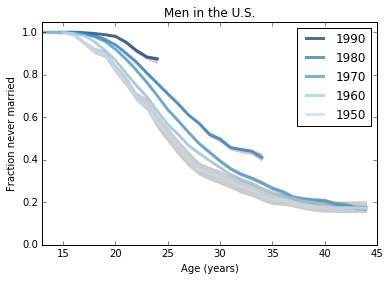

In [45]:
options_m = dict(formats=['pdf', 'png'], clf=False, title='Men in the U.S.')
PlotSurvivalFunctions('marriage7', sf_map_male, None, **options_m)

In [46]:
%time sf_map_male_pred = marriage.EstimateSurvivalByCohort(males, iters=11, cutoffs=cutoffs2, predict_flag=True)
del sf_map_male_pred[100]

CPU times: user 808 ms, sys: 0 ns, total: 808 ms
Wall time: 803 ms


Writing marriage8.pdf
Writing marriage8.png


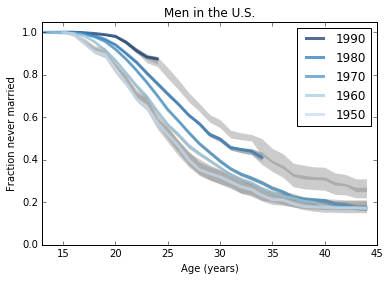

In [47]:
PlotSurvivalFunctions('marriage8', sf_map_male, sf_map_male_pred, **options_m)

In [48]:
MakePercentageTable(sf_map_male)

50 & 65 & 26 & 17 \\
60 & 70 & 29 & 17 \\
70 & 76 & 31 & 17 \\
80 & 81 & 44 & nan \\
90 & 88 & nan & nan \\


In [49]:
MakePercentageTable(sf_map_male_pred)

50 & 67 & 28 & 18 \\
60 & 69 & 29 & 17 \\
70 & 77 & 32 & 18 \\
80 & 81 & 44 & 25 \\
90 & 89 & 50 & 29 \\


Writing marriage9.pdf
Writing marriage9.png


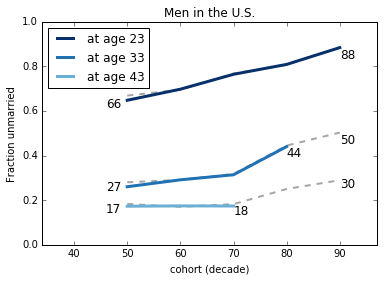

In [50]:
ages = [43, 33, 23]
PlotFractions(sf_map_male_pred, ages=ages, color='gray', linestyle='dashed', linewidth=2)
PlotFractions(sf_map_male, ages=ages, label_flag=True, alpha=1)

fontsize=12
thinkplot.Text(46, 0.66, '66', fontsize=fontsize)
thinkplot.Text(46, 0.29, '27', fontsize=fontsize)
thinkplot.Text(46, 0.19, '17', fontsize=fontsize)

thinkplot.Text(90, 0.88, '88', fontsize=fontsize)
thinkplot.Text(90, 0.50, '50', fontsize=fontsize)
thinkplot.Text(90, 0.30, '30', fontsize=fontsize)

thinkplot.Text(80, 0.44, '44', fontsize=fontsize)
thinkplot.Text(70, 0.18, '18', fontsize=fontsize)

thinkplot.Config(xlim=[34, 97], ylim=[0, 1], legend=True, loc='top left',
                 xlabel='cohort (decade)', ylabel='Fraction unmarried', 
                 title='Men in the U.S.')

thinkplot.Save(root='marriage9', **options)